# Método de Newton

Já implementamos o método do gradiente em detalhes, então não vamos levar tanto tempo com o método de Newton.
Na verdade, as diferenças são poucas, por enquanto.

O método de Newton é dado pelo passo $d^k$ que satisfaz
$$ \nabla^2 f(x^k)d^k = -\nabla f(x^k). $$

Uma parte extremamente importante desse método, é que ele resolve problemas quadráticos em uma iteração,
então vamos começar com um problema um pouco diferente.

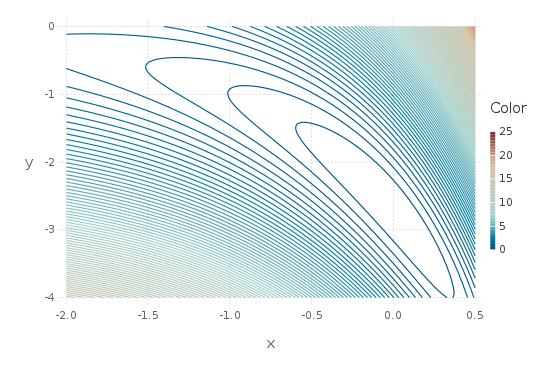

In [1]:
f(x) = (exp(x[1]) - 1)^2 + (x[2] + exp(x[1]+1))^2
∇f(x) = [2*(exp(x[1])-1) + 2*exp(x[1]+1)*(x[2] + exp(x[1]+1));
    2*(x[2] + exp(x[1]+1))]
∇²f(x) = [2*exp(x[1])+2*exp(x[1]+1)*(x[2]+2*exp(x[1]+1)) 2*exp(x[1]+1);
    2*exp(x[1]+1) 2]
x0 = [-1.5; 1.2];
using Gadfly
plot(z=(x,y)->f([x;y]), x=linspace(-2, 0.5, 100), y=linspace(-4, 0, 100),
Geom.contour(levels=100))

Para resolver sistemas lineares facilmente no Julia, podemos usar a barra invertida (`\`).

In [2]:
x = copy(x0);
d = -∇²f(x)\ ∇f(x);
x = x + d

2-element Array{Float64,1}:
 -0.910947
 -0.963809

In [3]:
d = -∇²f(x)\ ∇f(x);
x = x + d

2-element Array{Float64,1}:
  0.18903
 -2.29557

In [4]:
d = -∇²f(x)\ ∇f(x);
x = x + d

2-element Array{Float64,1}:
  0.142309
 -3.13047 

In [5]:
d = -∇²f(x)\ ∇f(x);
x = x + d

2-element Array{Float64,1}:
  0.0109226
 -2.72223  

In [6]:
d = -∇²f(x)\ ∇f(x);
x = x + d

2-element Array{Float64,1}:
  0.000774025
 -2.72025    

In [7]:
d = -∇²f(x)\ ∇f(x);
x = x + d

2-element Array{Float64,1}:
  5.96006e-7
 -2.71828   

In [8]:
norm(∇f(x))

5.84533653398241e-6

Então o método de Newton convergiu, e com poucas iterações.
Em muitos casos, o passo puro, sem busca linear, já é suficiente.

In [9]:
function newton_method(f, ∇f, ∇²f, x0; tol = 1e-5, max_iter = 1000, max_time = 60)
    exit_flag = 0
    
    x = copy(x0) # Cópia de x0
    iter = 0
    start_time = time()
    elapsed_time = 0.0
    fx = f(x)
    ∇fx = ∇f(x)
    while norm(∇fx) > tol
        ∇²fx = ∇²f(x)
        d = -∇²fx\∇fx
        x = x + d
        fx = f(x)
        ∇fx = ∇f(x)
        iter = iter + 1
        if iter >= max_iter
            exit_flag = 1
            break
        end
        elapsed_time = time() - start_time
        if elapsed_time >= max_time
            exit_flag = 2
            break
        end
    end
    return x, fx, ∇fx, exit_flag, iter, elapsed_time # Precisamos retornar o ponto encontrado
end

newton_method (generic function with 1 method)

In [10]:
x, fx, ∇fx, exit_flag, iter, elapsed_time = newton_method(f, ∇f, ∇²f, x0)

([5.96006e-7,-2.71828],1.0169196654785504e-12,[5.61437e-6,1.62689e-6],0,6,4.506111145019531e-5)

A implementação é essencialmente a mesma que a do método do gradiente sem a busca.

No entanto, veja que o método depende do ponto inicial.

In [11]:
x, fx, ∇fx, exit_flag, iter, elapsed_time = newton_method(f, ∇f, ∇²f, [-2.2;-2.0])

LoadError: SingularException(2)
while loading In[11], in expression starting on line 1

In [12]:
x, fx, ∇fx, exit_flag, iter, elapsed_time = newton_method(f, ∇f, ∇²f, [-3.2,-2.0])

([2999.67,-1.12637],Inf,[Inf,Inf],0,2,3.218650817871094e-5)

A primeira coisa a ver é que a matriz pode ser definida negativa, mas usando `\` não será possível.
Vamos usar o nosso código de LDLt.

In [13]:
function ldlt(A)
    (m,n) = size(A)
    if m != n
        error("Matriz tem que ser quadrada")
    end
    # Suporemos a matriz simétrica
    L = eye(A)
    D = zeros(n)
    ef = 0
    for j = 1:n
        s = 0.0;
        for k = 1:j-1
            s += L[j,k]^2*D[k]
        end
        D[j] = A[j,j] - s
        if abs(D[j]) < 1e-12
            ef = 1
        end
        for i = j+1:n
            s = 0.0
            for k = 1:j-1
                s += L[i,k]*L[j,k]*D[k]
            end
            L[i,j] = (A[i,j] - s)/D[j]
        end
    end
    return L, D, ef
end

ldlt (generic function with 1 method)

Agora adicionamos esse passo extra no método. Vamos continuar usando `\` para resolver o sistema triangular, mas para melhorar o método deveríamos mudar isso também.

In [14]:
function newton_method(f, ∇f, ∇²f, x0; tol = 1e-5, max_iter = 1000, max_time = 60)
    exit_flag = 0
    
    x = copy(x0) # Cópia de x0
    iter = 0
    start_time = time()
    elapsed_time = 0.0
    fx = f(x)
    ∇fx = ∇f(x)
    while norm(∇fx) > tol
        ∇²fx = ∇²f(x)
        L, D, ef = ldlt(∇²fx)
        if ef != 0
            exit_flag = 3
            break
        end
        if any(D .< 0)
            exit_flag = 4
            break
        end
        d = -L'\((L\∇fx)./D)
        x = x + d
        fx = f(x)
        ∇fx = ∇f(x)
        iter = iter + 1
        if iter >= max_iter
            exit_flag = 1
            break
        end
        elapsed_time = time() - start_time
        if elapsed_time >= max_time
            exit_flag = 2
            break
        end
    end
    return x, fx, ∇fx, exit_flag, iter, elapsed_time # Precisamos retornar o ponto encontrado
end

newton_method (generic function with 1 method)

In [15]:
x, fx, ∇fx, exit_flag, iter, elapsed_time = newton_method(f, ∇f, ∇²f, x0)
println("exit_flag = $exit_flag")

exit_flag = 0


In [16]:
x, fx, ∇fx, exit_flag, iter, elapsed_time = newton_method(f, ∇f, ∇²f, [-3.2;-2.0])
println("exit_flag = $exit_flag")

exit_flag = 4


In [17]:
x, fx, ∇fx, exit_flag, iter, elapsed_time = newton_method(f, ∇f, ∇²f, [-2.2;-2.0])

([-2.2,-2.0],3.6766121288190052,[-2.80173,-3.39761],4,0,0.0)